# Parsenet

In [1]:
import cv2
import helpers

import numpy as np
import mediapipe as mp

from matplotlib import pyplot as plt

e:\YAVU\.venv\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [2]:
det = helpers.model_processor(padding=10)

In [3]:
det.gen_face_route_index()

In [4]:
image = cv2.imread(r'E:\YAVU\Test_data\Inputs\testing2.jpg')
det.detect_for_image(image)

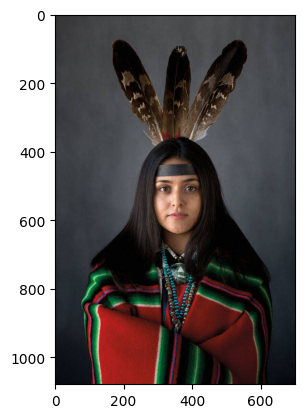

In [5]:
plt.imshow(image[:,:,::-1])

In [6]:
helper = helpers.FaceHelpers(image_mode=True)

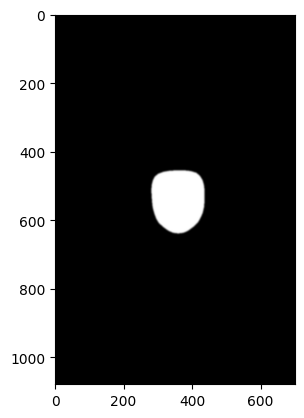

In [7]:
mask, center, _ = helper.gen_face_mask(image)
plt.imshow(mask)

In [8]:
center

array([358.11111111, 546.08333333])

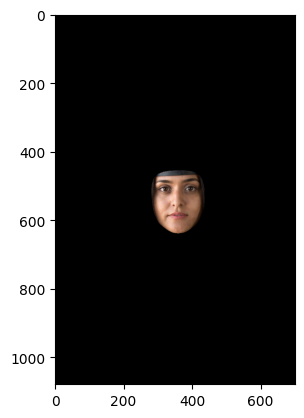

In [9]:
ext_image = helper.extract_face(image)
plt.imshow(ext_image[:,:,::-1])

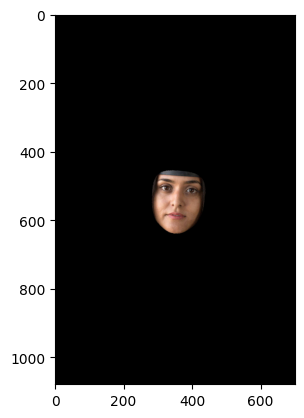

In [10]:
aligned, aff_mat = helper.alignment_procedure(ext_image)
plt.imshow(aligned[:,:,::-1])

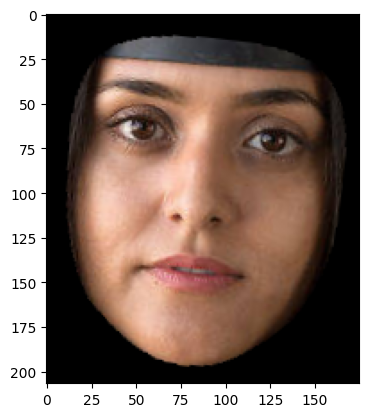

In [11]:
face, bbox = helper.crop_extracted_face(aligned, aff_mat)
original_shape = face.shape
plt.imshow(face[:,:,::-1])

In [12]:
import model_loaders
ml = model_loaders.model_loaders('GFPGAN', 0.5)
restored = ml.restore_wGFPGAN(face)

Load GFPGAN checkpoint from: e:\YAVU\weights\gfpgan\GFPGANv1.4.pth


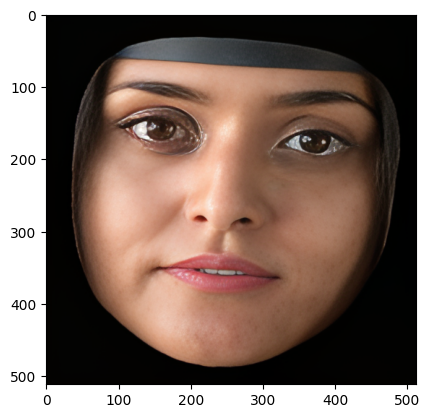

In [13]:
plt.imshow(restored[:,:,::-1])

In [14]:
import torch
from torchvision.transforms.functional import normalize
from facexlib.utils.misc import img2tensor, imwrite

In [15]:
face_parse = ml.load_parsenet()

In [16]:
# face_input = cv2.resize(restored, (512, 512), interpolation=cv2.INTER_LINEAR)
face_input = img2tensor(restored.astype('float32') / 255., bgr2rgb=True, float32=True)
normalize(face_input, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
face_input = torch.unsqueeze(face_input, 0).to('cuda')
with torch.no_grad():
    out = face_parse(face_input)[0]
out = out.argmax(dim=1).squeeze().cpu().numpy()

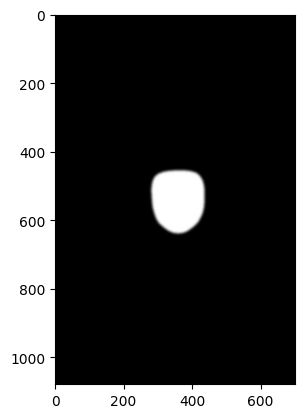

In [17]:
# mask_p = np.zeros(out.shape)
# MASK_COLORMAP = [0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 255, 0, 0, 0]
# for idx, color in enumerate(MASK_COLORMAP):
#     mask_p[out == idx] = color
#  blur the mask
mask = cv2.GaussianBlur(mask, (7, 7), 7)
mask = cv2.GaussianBlur(mask, (7, 7), 7)
# remove the black borders
# thres = 10
# mask[:thres, :] = 0
# mask[-thres:, :] = 0
# mask[:, :thres] = 0
# mask[:, -thres:] = 0
mask = mask / 255.

plt.imshow(mask)

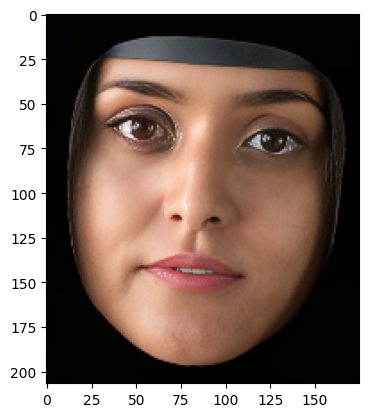

In [18]:
res_crop = cv2.resize(restored, (original_shape[1], original_shape[0]))
# mask = cv2.resize(mask, (original_shape[1], original_shape[0]))
plt.imshow(res_crop[:,:,::-1])

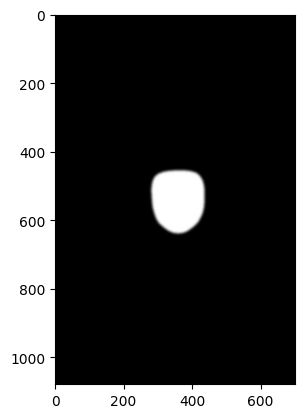

In [19]:
plt.imshow(mask)

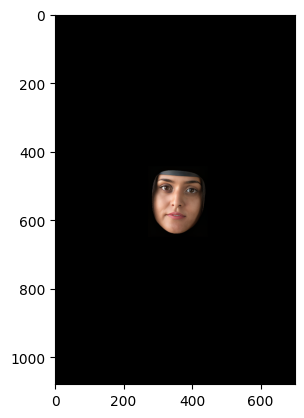

In [20]:
img = helper.paste_back_black_bg(res_crop, bbox, image)
plt.imshow(img[:,:,::-1])

In [21]:
# mask_full = np.zeros(image.shape[:2])
# mask_full[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]] = mask
# mask_full = np.zeros(image.shape)
# mask_full[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]] = mask

In [22]:
# plt.imshow(mask_full)

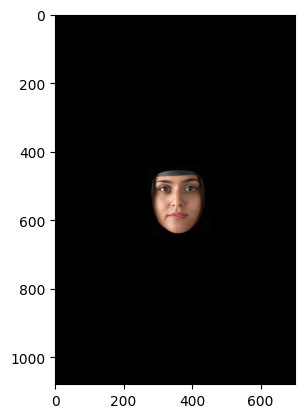

In [23]:
img = helper.unwarp_align(img, aff_mat)
plt.imshow(img[:,:,::-1])

In [24]:
# mask = helper.unwarp_align(mask, aff_mat)

In [25]:
# plt.imshow(mask)

In [26]:
inv_soft_mask = mask[:, :, None]
pasted_face = img

In [27]:
# plt.imshow(inv_soft_mask)

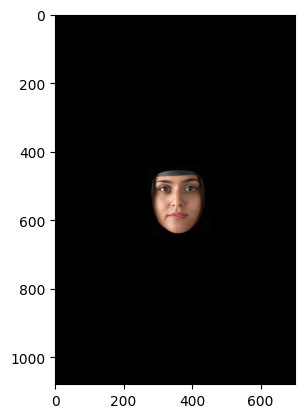

In [28]:
plt.imshow(pasted_face[:,:,::-1])

In [29]:
# final = inv_soft_mask * pasted_face + (1 - inv_soft_mask) * image
# final = (inv_soft_mask.astype(np.uint8)*255) * pasted_face + (1 - (inv_soft_mask.astype(np.uint8)*255)) * image
# final = cv2.seamlessClone(pasted_face, image, inv_soft_mask.astype(np.uint8)*255, center.astype(np.int16)-[100, 100], cv2.NORMAL_CLONE)
final = cv2.seamlessClone(pasted_face, image, mask.astype(np.uint8)*255, center.astype(np.int16), cv2.NORMAL_CLONE)

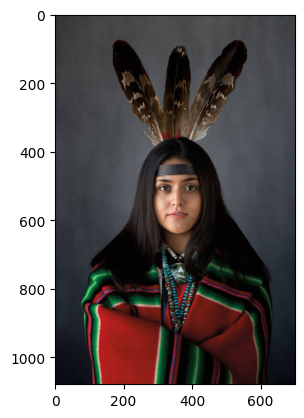

In [30]:
plt.imshow(final[:,:,::-1])

In [31]:
np.max(final)

255

In [32]:
cv2.imwrite(r'E:\YAVU\Test_data\Outputs\test.png', final)

True